- MNIST
- Dataloader, Transformation
- Multilayer Neural Net, activation function
- Loss and Optimizer
- Training loop (batch training)
- Model evaluation
- GPU support

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### CLI setup

Make sure run Tensorboard in this directory
```bash
$ docker exec -it ml_lab1 bash
$ conda activate tf2
$ cd D/pytorch_practice
$ tensorboard --logdir=runs
```

In [3]:
# Tensorboard
# writer = SummaryWriter('runs/mnist')

# modify the learning rate and uncomment below and comment above writer
writer = SummaryWriter('runs/mnist2')

In [4]:
# hyperparameters
input_size = 784  # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.01


In [5]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor())

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([3, 8, 8, 2, 7, 7])


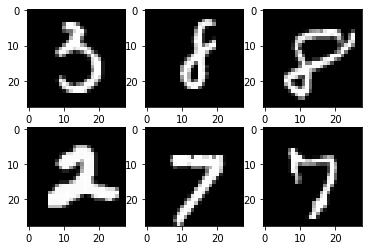

In [7]:
examples = iter(train_loader)
samples, labels = examples.next()

print(samples.shape, labels.shape)
print(labels[:6])

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')
    
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
        

In [9]:
model = NeuralNet(input_size, hidden_size, num_classes)

# Num of parameters to train
sum(p.numel() for p in model.parameters() if p.requires_grad)

model.to(device)

NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
writer.add_graph(model, samples.reshape(-1, 28*28).to(device))

In [12]:
# training loop
running_loss = 0.0
running_correct = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # lets reshape images as shape is 100,1,28,28 -> 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tensorboard
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        running_correct += (predictions == labels).sum().item()
        
        if (i+1)%100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, steps {i+1}/{n_total_steps}: loss={loss.item():.4f}')
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0
            

epoch 1/1, steps 100/938: loss=0.5047
epoch 1/1, steps 200/938: loss=0.1728
epoch 1/1, steps 300/938: loss=0.1511
epoch 1/1, steps 400/938: loss=0.1698
epoch 1/1, steps 500/938: loss=0.1257
epoch 1/1, steps 600/938: loss=0.1957
epoch 1/1, steps 700/938: loss=0.0330
epoch 1/1, steps 800/938: loss=0.1889
epoch 1/1, steps 900/938: loss=0.3349


In [13]:
labels1 = []
preds = []
# testing loop
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device) 
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        # tensorboard precision recall
        # https://pytorch.org/docs/stable/tensorboard.html >> add_pr_curve
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_predictions)
        labels1.append(predictions)
        
    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels1 = torch.cat(labels1)
        
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')
    
    classes = range(10)
    for i in classes:
        labels_i = labels1 == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

accuracy = 94.53
